In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json

d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework

* WADI_normaldata.csv: delete the first 4 lines of WADI_14days.csv  
* sensor_map.txt: map the tedious sensor names to "sensor0": "sensor126", sensor_map.txt stores the map

* use sensor0 data to do univariate autoencoder, but the result is very bad. 

* Version 2.0 wants to explore multivariate autoencoder and the effect of PCA

* 4 sensors are just NaN, so I delete them
* Besides, we have 50 NaN data. As 50 is quite small, I use Linear Interpolation to fill the missing data. 
* For test data, as attacked data are relatively scarse (5% of all), I selected less normal data than uniform sampling. 
* I take the average of "attack" for a sample of size 30 to indicate the anomaly level of the sequence(sample). When evaluating the model, I classify those with average "attack">0.2 as attacked, the others as normal. 
* Normalize the mse(mean squared error) between test_pred and test_y, try different threshold to get the best result. 
* The loss of the Network is not decreasing, but the F1 score is better than MAD-GAN's. This is astonishing. 

In [2]:
sensor_map = {}
with open("../data/WADI/sensor_map.txt", "r") as f:
    sensor_map = json.loads(f.read().replace("'", '"'))

In [3]:
def load_normal_data():
    data_df = pd.read_csv("../data/WADI/WADI_normaldata.csv")
    data_df = data_df.rename(columns = sensor_map)
    data_df = data_df[6*60*60:]
    return data_df

In [4]:
def load_anomaly_data():
    data_df = pd.read_csv("../data/WADI/WADI_attackdata_labelled.csv")
    data_df = data_df.rename(columns = sensor_map)
    return data_df

In [5]:
normal_data = load_normal_data()
anomaly_data = load_anomaly_data()
    

In [6]:
# try sensor 0 first

In [7]:
sensor_list = list(sensor_map.values())[:-1]
sensor_list_labelled = sensor_list+["attack"]

In [8]:
sensor_normal = normal_data[sensor_list].to_numpy()
sensor_anomaly = anomaly_data[sensor_list_labelled].to_numpy()

In [9]:
print(sensor_normal.shape)
print(sensor_anomaly.shape)

(1188001, 123)
(172801, 124)


In [10]:
np.sum(np.isnan(sensor_normal))


50

In [11]:
np.sum(np.isnan(sensor_anomaly))

0

In [12]:
def interp_1darray(data):
    assert len(data.shape)==1, "data is not 1d"
    num_index = [i for i in range(len(data)) if not np.isnan(data[i])]
    f= interpolate.interp1d(num_index, data[num_index])
    data_new = f(range(len(data)))
    return data_new
    

In [13]:
def interp_2darray(data):
    assert len(data.shape)==2," data is not 2d "
    new_data = data.copy().T
    for i in range(len(new_data)):
        if(np.sum(np.isnan(new_data[i]))>0):
            new_data[i] = interp_1darray(new_data[i])
    new_data = new_data.T
    return new_data
    

In [14]:
def normalize_1d(data):
    new_data = data.copy()
    min_ = min(new_data)
    max_ = max(new_data)
    if(max_-min_==0):
        new_data = np.ones(new_data.shape,dtype="double") 
    #print(data)
    else:
        new_data= (new_data-min_)/(max_-min_)
    #print(data)
    return new_data

def normalize_2d(data, axis = 1):
    new_data = data.copy()
    if(axis == 0):
        new_data = new_data.T
    #print(data.shape)
    for i in range(len(new_data)):
        new_data[i] = normalize_1d(new_data[i])
    if(axis == 0):
        new_data = new_data.T
        
    return new_data

In [15]:
sensor_normal_interp = interp_2darray(sensor_normal)

In [16]:
print("nan:", np.sum(np.isnan(sensor_normal_interp)))
sensor_normal_interp.shape

nan: 0


(1188001, 123)

In [17]:
sensor_normal_normalized = normalize_2d(sensor_normal_interp, axis = 0)
sensor_anomaly_normalized = normalize_2d(sensor_anomaly, axis = 0)

In [18]:
np.save("../data/WADI/normal1.0.npy", sensor_normal_normalized)
np.save("../data/WADI/anomaly1.0.npy", sensor_anomaly_normalized)

In [156]:
# delete first 6 hours
# sensor_normal_normalized = sensor_anomaly_normalized[6*60*60:, :]

In [19]:
print(sensor_normal_normalized.shape, sensor_anomaly_normalized.shape)

(1188001, 123) (172801, 124)


In [20]:
print("nan:", np.sum(np.isnan(sensor_normal_normalized)))

nan: 0


In [21]:
normal_len = len(sensor_normal_normalized)
anomaly_len = len(sensor_anomaly_normalized)
dimension = sensor_normal_normalized.shape[1]

In [22]:
#generate train_x

In [23]:
sample_size = 30
train_size = 10000
sample_step = np.floor((normal_len-sample_size)/(train_size-1)).astype(int)
print("sample_step: ", sample_step)

sample_step:  118


In [24]:
train_x = np.zeros((train_size, sample_size, dimension), dtype="double")

In [25]:
for i in range(train_size):
    train_x[i, :, :] = sensor_normal_normalized[i*sample_step: (i*sample_step+sample_size), :]

In [26]:
train_y = np.zeros((train_size, sample_size*dimension), dtype = "double")
for i in range(train_size):
    train_y[i] = train_x[i,:,:].ravel()

In [82]:
# generating test_set
pd.Series(sensor_anomaly_normalized[0:, 123]).describe()

In [27]:
test_size = 1000
sample_step=np.floor((anomaly_len-sample_size)/(test_size-1)).astype(int)
print("sample_step: ", sample_step)

sample_step:  172


In [28]:
test_index = np.array([i*sample_step for i in range(test_size)])
test_normal_index = np.array([i for i in test_index if np.mean(sensor_anomaly_normalized[i:(i+sample_size), -1])<0.2])
print("normal size:", len(test_normal_index))
left_index_index = np.array(range(0,len(test_normal_index), 7))
print("left size: ", len(left_index_index))
test_normal_index_left = test_normal_index[left_index_index]
test_index_final = np.array([i for i in test_index if (i not in test_normal_index) or (i in test_normal_index_left)])
print("final: ", len(test_index_final))

normal size: 940
left size:  135
final:  195


In [29]:
new_test_size = len(test_index_final)
print(new_test_size)

195


In [30]:
test_x = np.zeros((new_test_size, sample_size, dimension), dtype = "double")
for i in range(new_test_size):
    test_x[i,:,:] = sensor_anomaly_normalized[test_index_final[i]:(test_index_final[i]+sample_size), :-1]
test_y = np.zeros((new_test_size, sample_size*dimension), dtype = "double")
for i in range(new_test_size):
    test_y[i] = test_x[i,:,:].ravel()

In [31]:
test_attack_level = np.array([np.mean(sensor_anomaly_normalized[i:(i+sample_size), -1]) for i in test_index_final])

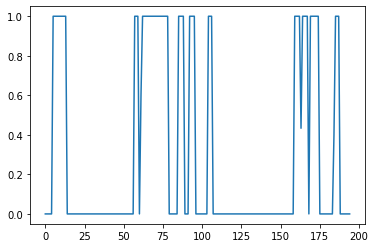

In [32]:
plt.plot(range(len(test_index_final)), test_attack_level)

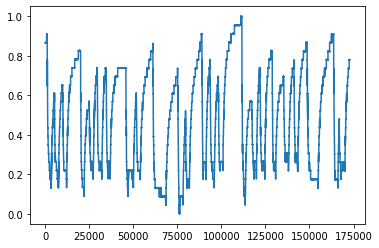

In [42]:
plt.plot(range(anomaly_len), sensor_anomaly_normalized[:,4])
#plt.plot(range(anomaly_len), [1 if i in test_index_final else 0 for i in range(anomaly_len)])

In [77]:
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    pre = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    

In [78]:
def get_pred_errors(model, test_x, test_y):
    test_pred = model.predict(test_x)
    return np.array([mean_squared_error(test_y[i], test_pred[i]) for i in range(len(test_y))])

In [85]:
def eval_model(errors, attack_levels, th_int=0.1):
    err_normalized = normalize_1d(errors)
    thresholds = np.arange(0.5*th_int,1,th_int)
    print("corr: ", np.corrcoef(err_normalized, attack_levels))
    attack_th = np.array([1 if i>0.2 else 0 for i in attack_levels])
    
    normal_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==0])
    anomaly_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==1])
    print("normal_err: ", pd.Series(normal_err).describe())
    print("anomaly_err:", pd.Series(anomaly_err).describe())
    
    
    res = {"pre":np.zeros((len(thresholds))), "rec":np.zeros((len(thresholds))), "F1":np.zeros((len(thresholds)))}
    for i in range(len(thresholds)):
        th = thresholds[i]
        #print("Threshold = ", th)
        err_thd = np.array([1 if i >th else 0 for i in err_normalized])
        pre, rec, F1=get_eval(attack_th, err_thd)
        res["pre"][i]=pre
        res["rec"][i] = rec
        res["F1"][i] = F1
    plt.subplot(1,3,1)
    plt.plot(thresholds, res["pre"])
    plt.xlabel("threshold")
    plt.ylabel("pre")
    plt.title("pre")
    
    plt.subplot(1,3,2)
    plt.plot(thresholds, res["rec"])
    plt.xlabel("threshold")
    plt.ylabel("rec")
    plt.title("rec")
    
    plt.subplot(1,3,3)
    plt.plot(thresholds, res["F1"])
    plt.xlabel("threshold")
    plt.ylabel("F1")
    plt.title("F1")
    return res

In [87]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(800, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(800, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)



data_dim: 3690
Epoch 1/5
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 2/5
10000/10000 [==============================] - 39s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 3/5
10000/10000 [==============================] - 40s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 4/5
10000/10000 [==============================] - 40s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 5/5
10000/10000 [==============================] - 39s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328


In [89]:
adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)

Epoch 1/5
10000/10000 [==============================] - 40s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 2/5
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 3/5
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 4/5
10000/10000 [==============================] - 39s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328
Epoch 5/5
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.4328 - mean_squared_error: 0.4328


corr:  [[1.        0.1627779]
 [0.1627779 1.       ]]
normal_err:  count    135.000000
mean       0.500674
std        0.229256
min        0.000000
25%        0.329543
50%        0.542079
75%        0.679954
max        0.904726
dtype: float64
anomaly_err: count    60.000000
mean      0.582413
std       0.250342
min       0.180899
25%       0.336266
50%       0.607435
75%       0.755195
max       1.000000
dtype: float64


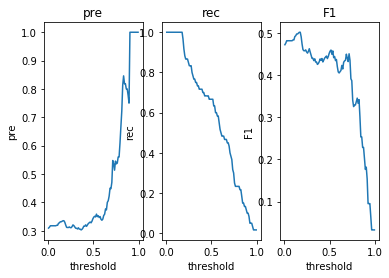

In [90]:
eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01);

corr:  [[1.         0.16277434]
 [0.16277434 1.        ]]
normal_err:  count    135.000000
mean       0.500673
std        0.229255
min        0.000000
25%        0.329543
50%        0.542079
75%        0.679953
max        0.904727
dtype: float64
anomaly_err: count    60.000000
mean      0.582410
std       0.250341
min       0.180900
25%       0.336266
50%       0.607426
75%       0.755189
max       1.000000
dtype: float64


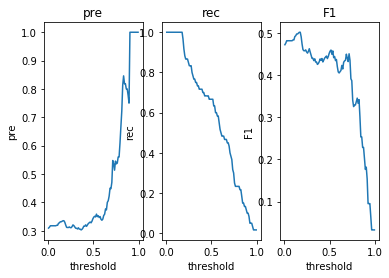

In [88]:
eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01);


In [ ]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(800, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    #tf.keras.layers.Dense(, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)

data_dim: 3690
Epoch 1/5
 7136/10000 [====================>.........] - ETA: 50s - loss: 0.4328 - mean_squared_error: 0.4328